# <center> Using the language R to access multiple GeoNet sites with GNSS data

In this notebook we will make a map of GNSS stations in an area then get the data from the station. By the end of this notebook you should know how to make a map of stations like the one below <img src="map.png"> and graph the data from all these stations like the one below <img src="plot.png">

## &nbsp; Table of contents

### 1. Introduction
### 2. Set Up 
### 3. Define Area of Interest
### 4. Get Site Data
### 5. Map Sites
### 6. Get GNSS Data for All Sites in an Area
### 7. Plot Data 
### 8. Save Data

## &nbsp; 1. Introduction


In this tutorial we will be learning how to use R to access GNSS (commonly referred to at GPS) data from the multiple continuous GNSS sites, in an area, in the GeoNet and PositioNZ networks. GeoNet has a API (Application Programming Interface) to access its GNSS data. You do not need to know anything about APIs to use this tutorial but if you would like more info see https://fits.geonet.org.nz/api-docs/.

R is a language made for statisticians by statisticians. It is an open source language which anyone can make a package for. This means that R has a lot of useful functions for all kinds of research.

This tutorial assumes that you have basic knowledge of the language R, but basic knowledge of any programming language should be sufficient to follow this tutorial.

All data will be saved into R as a data frame which is much like, what would be called, a dictionary in other languages, but with a few more restrictions to the data structure. To understand more about data frames go to https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/data.frame

We will also be using the packages geojsonR (https://cran.r-project.org/web/packages/geojsonR/geojsonR.pdf ) and maps (https://cran.r-project.org/web/packages/maps/maps.pdf )

###### About Geonet GNSS data

GeoNet uses GNSS technology to work out the precise positions of over 190 stations in and around NZ everyday. These positions are used to generate a displacement timeseries for each station so we can observe how much and how quickly each station moves. <br>
This data has 3 components:
<ul>
    <li> The displacement in the east west direction where east is a positive displacement. This has a typeID of "e"
    <li> The displacement in the north south direction where north is a positive displacement. This has a typeID of "n"
    <li> The displacement in the up down direction where up is a positive displacement. This has a typeID of "u"</ul>
For more on data types go to http://fits.geonet.org.nz/type (for best formatting use firefox) 

## &nbsp; 2. Set Up 

###### Install Packages

In [ ]:
install.packages("geojsonR")
install.packages("maps")

Note this code might take some time to run but you only need to run this ONCE. 

###### Call libraries

In [25]:
library(httr)
library(geojsonR)
library(maps)

The library httr (https://cran.r-project.org/web/packages/httr/vignettes/quickstart.html) is a base package of R and will not need to be imported. To find out more about geojsonR go to(https://cran.r-project.org/web/packages/geojsonR/geojsonR.pdf ) and to find more about maps go to (https://cran.r-project.org/web/packages/maps/maps.pdf )

###### Set URL

In [26]:
base_url <- "http://fits.geonet.org.nz/"
endpoint <- "site"

The base URL should be set as above, and the endpoint is set to site to get the site data. There are other endpoints which will return different information such as plot and observation. To learn more go to https://fits.geonet.org.nz/api-docs/.

###### Set data type

In [27]:
type <- "e"

We want to look for sites which return GNSS data as such we set type to one of the 3 data types for GNSS data. ` type <- "e"` ,` type <- "n"` and `type <- "u"` will all give us the same sites. 

## &nbsp; 3. Define Area of Interest

You can define you area of interest in the shape of any polygon. In this example we will be looking at a square as our polygon. 

###### Define the longitude and latitude of the point of interest

In [78]:
point_long <- 178
point_lat <- -38.5
maxradius <- 1

Define the longitude and latitude of the point of interest as well as how far out from that point you want to look (`maxradius`) in . e.g. The north east point of our box will be 177 long and -37.5 lat.

###### Set parameters for area of interest.

In [79]:
long_max<- point_long + maxradius
long_min<- point_long - maxradius
lat_max <- point_lat - maxradius
lat_min <- point_lat + maxradius

This set the 4 edge points of the box we will look for GNSS sites in.

###### Map this box

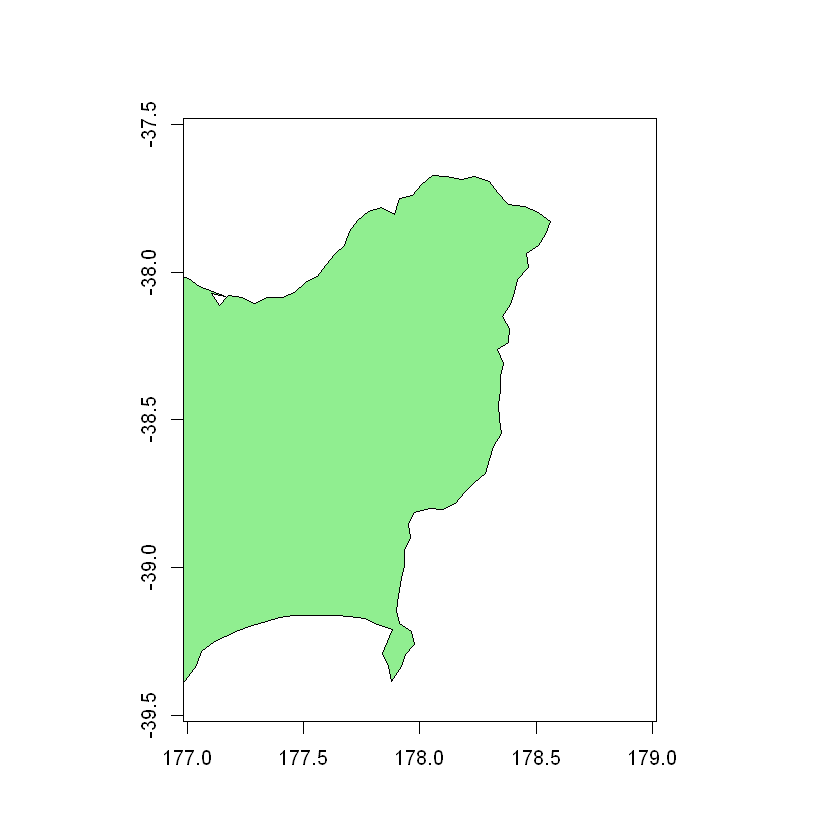

In [81]:
map("nz",xlim=c(long_min,long_max),ylim=c(lat_max,lat_min), fill=TRUE, col="lightgreen")
map.axes()

This map shows all the area that will we will look for GNSS stations.  `xlim=c(long_min,long_max)` says that the x limits of the map will be the longitude limits. `ylim=c(lat_max,lat_min)` says that the y limits of the map will be the latitude limits. 

###### Make box

In [65]:
ploy <- paste(long_max,"+",lat_max
              ,",",long_max,"+",lat_min
              ,",",long_min,"+",lat_min
              ,",",long_min,"+",lat_max
              ,",",long_max,"+",lat_max, sep="")

Here we use the points worked out before to make a box that is formatted in the right way to put into our URL later

## &nbsp; 4. Get Site Data

###### Combine information to get full URL

In [66]:
full_url <- paste(base_url,endpoint,"?typeID=",type,"&within=POLYGON((", ploy, "))", sep="")

Combine the information to make the full URL. sep="" make sure there is no space between each piece of information. In this case you get the URL http://fits.geonet.org.nz/site?typeID=e&within=POLYGON((179.5+-39.5,179.5+-37.5,177.5+-37.5,177.5+-39.5,179.5+-39.5))

###### Get sites

In [67]:
allGNSSsites <- FROM_GeoJson(full_url)[[1]]

Use `FROM_GeoJson` to get all the sites using the above URL. `[[1]]` is saying only look at the 1st row of data and is needed becuase all data is in the 1st row with this row saying that it is site data. `FROM_GeoJson` will also translate the data into a datafram as the the data at the URL is in a format called JSON(JavaScript Object Notation) or more specifically GeoJSON(Geographical JavaScript Object Notation) http://geojson.org/

###### See the number of sites

In [68]:
paste("There are" , length(allGNSSsites), "sites in the the box of interest")

[1] "There are 28 sites in the the box of interest"

We only want to know the site ID, name and longitude and latitude of each site so I will make a new data frame will only this information in it.

###### Initialize this data frame

In [69]:
sites <- data.frame("siteID"= allGNSSsites[[1]]$properties$siteID,
                "longitude" =allGNSSsites[[1]]$geometry$coordinate[1], 
                "latitude" =allGNSSsites[[1]]$geometry$coordinate[2],
                "name"= allGNSSsites[[1]]$properties$name)

Take the first `[[1]]` data point and extract the values for siteID, longitude and latitude. Then format this into a data frame

###### Complete this data frame

In [70]:
for (i in 2:length(allGNSSsites)){
    temp <- data.frame("siteID"=allGNSSsites[[i]]$properties$siteID, 
                      "longitude" =allGNSSsites[[i]]$geometry$coordinate[1], 
                      "latitude" =allGNSSsites[[i]]$geometry$coordinate[2],
                      "name"= allGNSSsites[[i]]$properties$name)
    sites <- rbind(sites, temp)
}

Do what was done for the first data point for each data point adding it to the data frame with `rbind`.

###### Print out this data frame

In [71]:
sites[]

siteID,longitude,latitude,name
AHTI,178.0460,-38.41145,Ahititi
ANAU,178.2912,-38.26821,Anaura Bay
CNST,178.2111,-38.48797,Carnagh Station
FRTN,177.4099,-38.93930,Frasertown
GISB,177.8860,-38.63534,Gisborne
HANA,177.5694,-38.68682,Hangaroa
HIKB,178.3034,-37.56104,Hicks Bay
KOKO,177.6678,-39.01611,Kokohu
KUTA,177.0698,-39.17226,Te Kuta
MAHI,177.9070,-39.15256,Mahia Peninsula


## &nbsp; 5. Map Sites

###### Set parameters for map

In [72]:
xhigh <- max(sites$longitude)+ .3
xlow <- min(sites$longitude)- .3
yhigh <- max(sites$latitude)+ .3
ylow <- min(sites$latitude)- .3

We can take the maximum longitude to be the maximum longitude of all the sites and the same for minimum and latitude. 
So that the data is not on the edge of the map we can make sure all points are at least 0.3 from the edge of the map by modifying the maximum and minimum,longitude and latitude by 0.3. 

###### Plot the map with x,y parameters

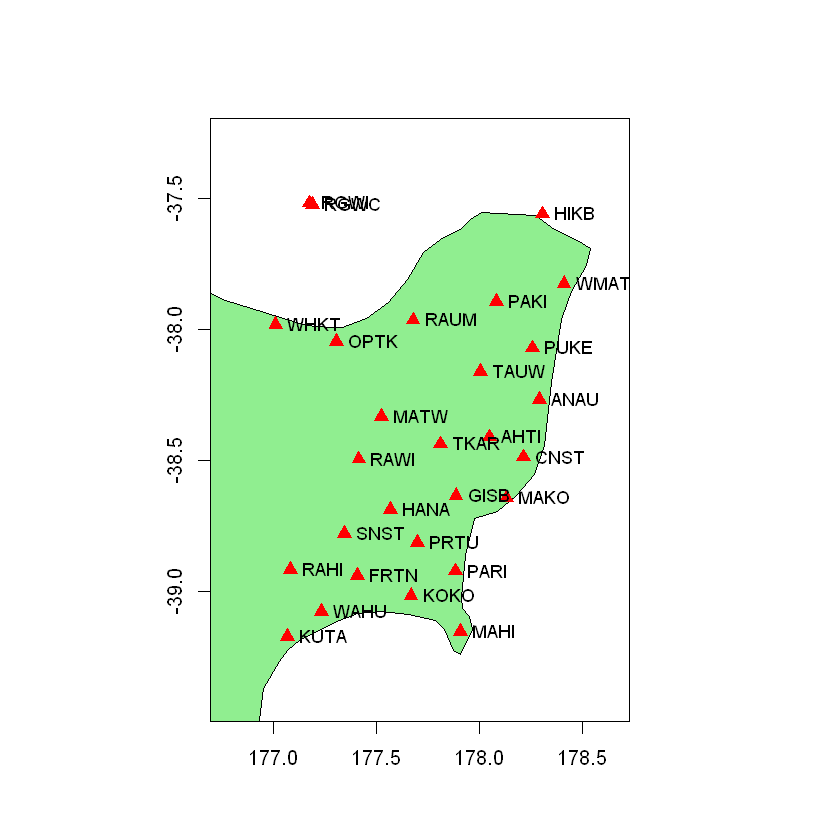

In [73]:
map(xlim=c(xlow,xhigh),ylim=c(ylow,yhigh), fill=TRUE, col="lightgreen")
points(sites$longitude, sites$latitude, pch=17, cex=1.3, col='red')
labels <- paste(sites$siteID)
text(sites$longitude, sites$latitude, labels=labels, cex=.9, pos=4)
map.axes()

The function `map` makes the base map. The function `points` makes a point for each site.
    The point is given an x,y coordinate of its longitude and latitude.
    The function`pch` say what shape will be plotted `pch=17` say the shape will be triangle with its centre on the point.
    The function `cex` say the size of the shape will be.
    The label is the siteID and `pos=4` says it will to the right of the point.
If you right click on this plot in the notebook you can save it. 
For more about what you can do with maps go to http://www.geog.uoregon.edu/GeogR/ or run `library(help ="maps")`

## &nbsp; 6. Get GNSS Data for All Sites in an Area

###### Make a function that will take a siteID and return a data frame with east, north and up data from that site.

In [41]:
get_gnss<- function(site){
    # This function takes a site ID as a string
    # and returns a dataframe with all the observation data for that site
    
    #Set up
    base_url <- "http://fits.geonet.org.nz/"
    endpoint <- "observation"
    
    #Get East Data
    type <- "e"
    full_url <- paste(base_url,endpoint,"?typeID=",type,"&siteID=",site, sep="")
    east <- GET(full_url)
    
    #Get North Data
    type <- "n"
    full_url <- paste(base_url,endpoint,"?typeID=",type,"&siteID=",site, sep="")
    north <- GET(full_url)
    
    #Get Up Data
    type <- "u"
    full_url <- paste(base_url,endpoint,"?typeID=",type,"&siteID=",site, sep="")
    up <- GET(full_url)
    
    #Unpack data into data frames
    df_e <- content(east, encoding ="UTF-8")
    df_n <- content(north, encoding ="UTF-8")
    df_u <- content(up, encoding ="UTF-8")
    
    # Make into one data frame
    new_df <- data.frame(
    df_e$'date-time', 
    df_e$'e (mm)', 
    df_n$'n (mm)',
    df_u$'u (mm)')
    colnames(new_df) = c("date-time", "e (mm)", 'n (mm)','u (mm)')
    
    # Return data frame
    return(new_df)
}

For more on the code in this fuction go to https://github.com/JenLowe/data_tutorials/blob/master/GNSS_Data/R/Introduction_to_GNSS_data_using_FITS_in_R.ipynb.

###### Run above function on all sites in our data frame

In [ ]:
data <- list()
for (i in 1:length(allGNSSsites)){
    data[[levels(sites$siteID[1])[i]]]<-get_gnss(levels(sites$siteID[1])[i])
    }

`data <- list()` initialize a list to save each sites dataframe of data in. The list of sites is then looped over and have the above function run on them, whith the result being saved into the list data with the name of the site.

## &nbsp; 7. Plot Data

###### Plot the east data for the site CNST

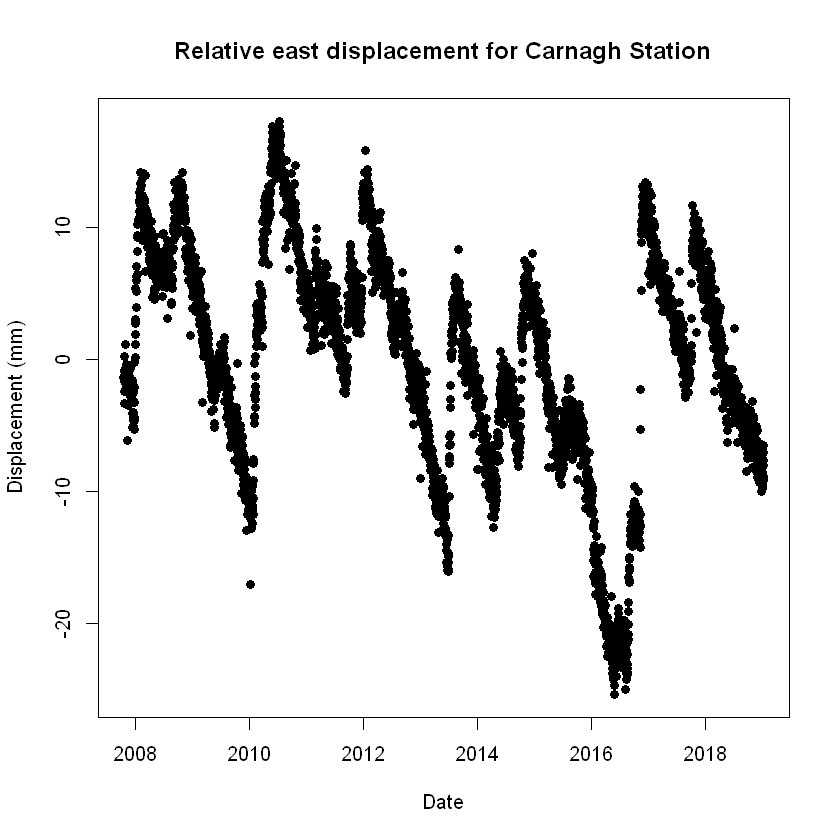

In [82]:
title <- paste("Relative east displacement for Carnagh Station" )
plot(data[["CNST"]]$'date-time', data[["CNST"]]$'e (mm)',main= title, xlab = "Date", ylab = "Displacement (mm)", pch = 16)

`data[["CNST"]]` say call the dataframe with name "CNST". We named each dataframe the same as it siteID, so this calls the data from the site with the siteID of "CNST".<br>
The data `data[["CNST"]]$'date-time'` is the data time data in the east data frame. This is set to be on the x axis. ` data[["CNST"]]$'e (mm)'` is the displacement data from the east data frame. This is set to be on the y axis. ` main= "Relative east displacement for CNST"` gives the graph its title. ` xlab = "Date", ylab = "Displacement (mm)"` give the graph its x and y axis titles. `pch  = 16` says that each data point will be put on the graph as a circle filled in point. To save this plot right click on it in this notebook

## &nbsp; 8. Save Data

In [44]:
for (i in 1:length(data)){
    name <- paste(levels(sites$siteID[1])[i], ".csv")
    write.csv(data[[levels(sites$siteID[1])[i]]], name)
}

`levels(sites$siteID[1])` is the list of siteIDs so this `for` loop make a cvs file for each site. The csv will be named after the site ID. eg. The csv with the data from CNST with be named CNST.csv

## Useful links

<ul>
    <li>This notebook uses the language R https://www.r-project.org/
    <li>This notebook uses the library httr https://cran.r-project.org/web/packages/httr/vignettes/quickstart.html
    <li>To understand more about data frames go to https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/data.frame
    <li>To understand the `get_gnss` function go to (right place in github)
    <li>To learn more about the packages geojsonR go to https://cran.r-project.org/web/packages/geojsonR/geojsonR.pdf  
    <li>To understad more about maps in R go to https://cran.r-project.org/web/packages/maps/maps.pdf
    <li>To learn more about what maps can be made in R go to http://www.geog.uoregon.edu/GeogR/ 
    <li>More tutorials on GNSS data can be found at (link to right place in github) 
    <li>To learn more about station codes go to https://www.geonet.org.nz/data/supplementary/channels
    <li>For more on data types in FITS go to http://fits.geonet.org.nz/type (for best formatting use firefox)
    <li>For more on FITS go to https://fits.geonet.org.nz/api-docs/    
</ul>